In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier


In [74]:
# Load data from a CSV file
file_path = 'DPW_data_r3y.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Display the first few rows of the data
data.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date
0,1,827262,1,f,open,0,DPW - Administration,Park Shelter,543,2024-03-12 10:50:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-03-12
1,2,720661,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-20 07:52:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-03-20
2,3,722010,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-24 07:44:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-03-24
3,4,846915,1,f,open,0,Police - Zones 1-6,Illegal Parking,417,2024-05-19 12:24:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-05-19
4,5,853708,1,f,open,0,DPW - Facilities,City Facility,375,2024-06-06 23:04:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-06-06


In [75]:
# Filter the dept == 'DPW - Street Maintenance'
dpw_sm = data[data['dept'] == 'DPW - Street Maintenance']
dpw_sm.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-07-08
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-28
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-05
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-06
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,Pittsburgh,NaN,4.200398e+10,6.0,NaN,NaN,40.446306,-80.027041,EXACT,2023-05-22


In [76]:
# Check duplicated data
dups = dpw_sm.duplicated()
dups.any()

np.False_

In [77]:
print(dpw_sm["request_type_name"].value_counts())
print(dpw_sm.describe())

request_type_name
Potholes                    10801
Litter, Public Property      6286
Snow/Ice removal             6135
Overgrowth                   3362
Street Cleaning/Sweeping     3237
                            ...  
Dumpster (on Street)            1
Repair City Steps               1
Storm Damage                    1
Recycling Violation             1
Brick or Block Repair           1
Name: count, Length: 65, dtype: int64
                 _id       group_id  num_requests   status_code  \
count   39090.000000   39090.000000  39090.000000  39090.000000   
mean   622270.571323  775751.960578      1.018854      1.041494   
std    203455.613641   95453.034213      0.197006      0.376899   
min        65.000000  620415.000000      1.000000      0.000000   
25%    611757.500000  693613.750000      1.000000      1.000000   
50%    682809.500000  774244.000000      1.000000      1.000000   
75%    755159.000000  857294.250000      1.000000      1.000000   
max    815687.000000  926116.00000

# **Part 3 Predict the high risk requests.**
Definition of "high risk": 
1. if the request is reported more than once, meaning that the request might be urgent or has been delayed
for some reason. ===> attribute 'num_requests' refers to the number of aggregated requests
- num_requests > 1 ===> is_multiple_request = 1
- otherwise ===> is_multiple_request = 0
2. if the the request didn't close and has been opened for over one month, it is high-risk.
- status_name = ["in progress","open","on hold"] and open days > 30 ===>  not_close_long_time_request = 1
- otherwise ===> not_close_long_time_request = 0

In [78]:
# feature exploration and engineering
# 1. repeat requests or not
# assume num_requests >1 as the sign of upgraded or high risk request
# num_requests: the 3-1-1 system clusters some requests about the same problem (for instance, the same pothole) together. The number of requests in the group is reflected in the num_requests field.

# calculate the number of num_requests ==1 and >1
num_gt1 = len(dpw_sm[dpw_sm['num_requests'] > 1])
num_eq1 = len(dpw_sm[dpw_sm['num_requests'] == 1])

print(f"num_requests > 1 : {num_gt1}")
print(f"num_requests = 1 : {num_eq1}")

# Create a copy and New target label: "is_multiple_request"
dpw_sm_part3 = dpw_sm.copy()
dpw_sm_part3['is_multiple_request'] = (dpw_sm_part3['num_requests'] > 1).astype(int)
print(f"Percentage of multiple requests:{num_gt1/(num_gt1+num_eq1)*100: .2f}%")

# Look at the type distribution of multiple requests
multiple_requests = dpw_sm_part3[dpw_sm_part3['is_multiple_request'] == 1]
multiple_requests['request_type_name'].value_counts().head(10)

num_requests > 1 : 537
num_requests = 1 : 38553
Percentage of multiple requests: 1.37%


request_type_name
Potholes                    151
Overgrowth                  136
Snow/Ice removal             75
Litter, Public Property      45
Tree Fallen Across Road      30
Street Cleaning/Sweeping     20
Drainage/Leak                19
Leaves/Street Cleaning       16
City Steps, Need Cleared     10
Litter Can, Public            7
Name: count, dtype: int64

In [79]:
# 2. closed requests or not
# if the the request didn't close and has been opened over 4 months, it is high-risk.
print(dpw_sm_part3["status_name"].value_counts())
not_close = dpw_sm_part3[dpw_sm_part3["status_name"].isin(["in progress","open","on hold"])].copy()
not_close["request_type_name"].value_counts().head(10)

status_name
closed         37111
in progress     1187
open             782
on hold           10
Name: count, dtype: int64


request_type_name
Litter, Public Property     489
Potholes                    349
Street Cleaning/Sweeping    162
Litter Can, Public          147
Overgrowth                  122
Drainage/Leak               112
Public Right of Way          89
Barricades                   81
Snow/Ice removal             67
Trail Maintenance            59
Name: count, dtype: int64

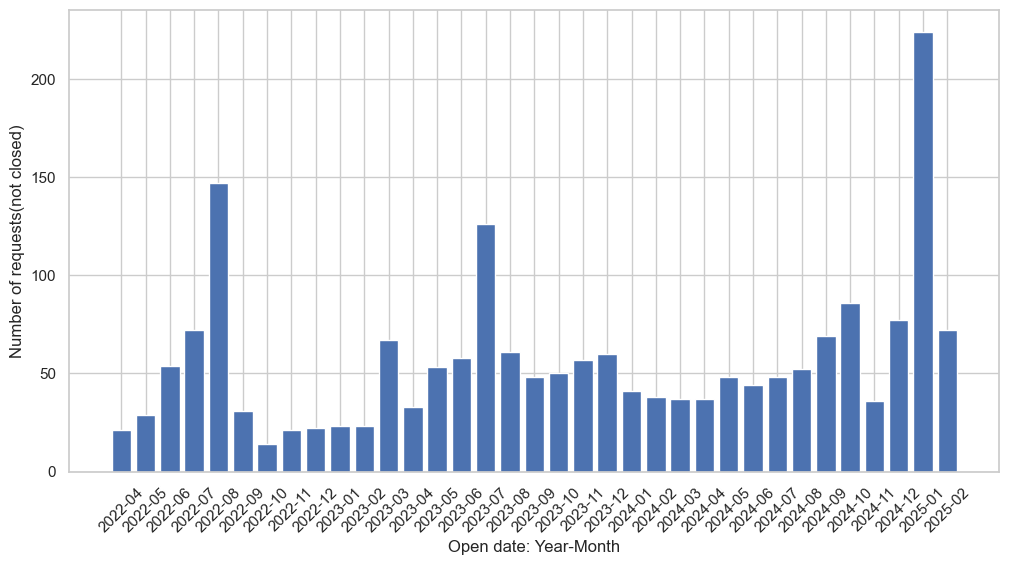

In [80]:
# see the month distribution of not close requests and decided to exclude the cases within 30 days of the high risk label
not_close['create_date_et'] = pd.to_datetime(not_close['create_date_et'])
not_close['create_year']=not_close['create_date_et'].dt.year
not_close['create_month']=not_close['create_date_et'].dt.month
monthly_counts = not_close.groupby(['create_year', 'create_month'])['num_requests'].count().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts['create_year'].astype(str) + '-' + monthly_counts['create_month'].astype(str).str.zfill(2), monthly_counts['num_requests'])
plt.xlabel('Open date: Year-Month')
plt.ylabel("Number of requests(not closed)")
plt.xticks(rotation=45)
plt.show()

In [81]:
# create the new target label: not_close_long_time_request long_time ==> more than 30 days
dpw_sm_part3['create_date_et'] = pd.to_datetime(dpw_sm_part3['create_date_et'])
current_date = dpw_sm_part3['create_date_et'].max()
dpw_sm_part3['days_open'] = (current_date - dpw_sm_part3['create_date_et']).dt.days
filtered_requests = dpw_sm_part3[
    (dpw_sm_part3['status_name'] != 'closed') & (dpw_sm_part3['days_open']> 30)
]
dpw_sm_part3['not_close_long_time_request'] = 0  # 初始化为 0
dpw_sm_part3.loc[filtered_requests.index, 'not_close_long_time_request'] = 1
dpw_sm_part3.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date,is_multiple_request,days_open,not_close_long_time_request
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-07-08,0,577,1
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-28,0,160,0
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-05,0,152,0
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-06,0,182,0
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,6.0,NaN,NaN,40.446306,-80.027041,EXACT,2023-05-22,0,624,1


In [83]:
count_1 = dpw_sm_part3['not_close_long_time_request'].sum()
print(count_1)
print(f"Percentage of 'not_close_long_time_request': {(count_1/len(dpw_sm_part3))*100:.2f}%")

1692
Percentage of 'not_close_long_time_request': 4.33%


In [89]:
# extract create month and create one new categorical feature 'create_month'
dpw_sm_part3['create_month'] = dpw_sm_part3['create_date_et'].dt.month
# create 'is_weekend' feature
dpw_sm_part3['is_weekend'] = dpw_sm_part3['create_date_et'].dt.dayofweek.isin([5, 6]).astype(int)

# create 'is_working_hours' feature
dpw_sm_part3['is_working_hours'] = (
    (dpw_sm_part3['create_date_et'].dt.hour >= 9) & (dpw_sm_part3['create_date_et'].dt.hour < 17)
).astype(int)

In [90]:
dpw_sm_part3.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,...,longitude,geo_accuracy,date,is_multiple_request,days_open,not_close_long_time_request,high_risk,create_month,is_weekend,is_working_hours
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,...,NaN,NULL_COORDINATES,2023-07-08,0,577,1,1,7,1,1
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,...,NaN,NULL_COORDINATES,2024-08-28,0,160,0,0,8,0,0
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,...,NaN,NULL_COORDINATES,2024-09-05,0,152,0,0,9,0,1
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,...,NaN,NULL_COORDINATES,2024-08-06,0,182,0,0,8,0,1
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,...,-80.027041,EXACT,2023-05-22,0,624,1,1,5,0,1


In [ ]:
<!-- # sort by neighborhood and date
dpw_sm_part3 = dpw_sm_part3.sort_values(by=['neighborhood', 'create_date_et'])

# 滚动统计函数
def get_rolling_counts(df, group_col, time_col, window, label):
    rolled = (
        df
        .groupby(group_col)
        .apply(lambda g: g.set_index(time_col).rolling(window)['neighborhood'].count())
        .reset_index(name=label)
    )
    return rolled

# 计算两个滚动窗口统计
rolling_7d = get_rolling_counts(dpw_sm_part3, 'neighborhood', 'create_date_et', '7D', 'requests_last_week')
rolling_3d = get_rolling_counts(dpw_sm_part3, 'neighborhood', 'create_date_et', '3D', 'requests_last_3_days')

# 合并回原始表
dpw_sm_part3 = (
    dpw_sm_part3
    .merge(rolling_7d, on=['neighborhood', 'create_date_et'], how='left')
    .merge(rolling_3d, on=['neighborhood', 'create_date_et'], how='left')
)

dpw_sm_part3[['neighborhood', 'create_date_et', 'requests_last_week', 'requests_last_3_days']].head() -->

C:\Users\joranY\AppData\Local\Temp\ipykernel_9428\675376372.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index(time_col).rolling(window)['neighborhood'].count())
C:\Users\joranY\AppData\Local\Temp\ipykernel_9428\675376372.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.set_index(time_col).rolling(window)['neighborhood'].count())


,neighborhood,create_date_et,requests_last_week,requests_last_3_days
0,Allegheny Center,2022-04-02 16:44:00,1.0,1.0
1,Allegheny Center,2022-04-20 09:31:00,1.0,1.0
2,Allegheny Center,2022-04-24 13:32:00,2.0,1.0
3,Allegheny Center,2022-05-10 07:37:00,1.0,1.0
4,Allegheny Center,2022-05-13 09:13:00,2.0,1.0


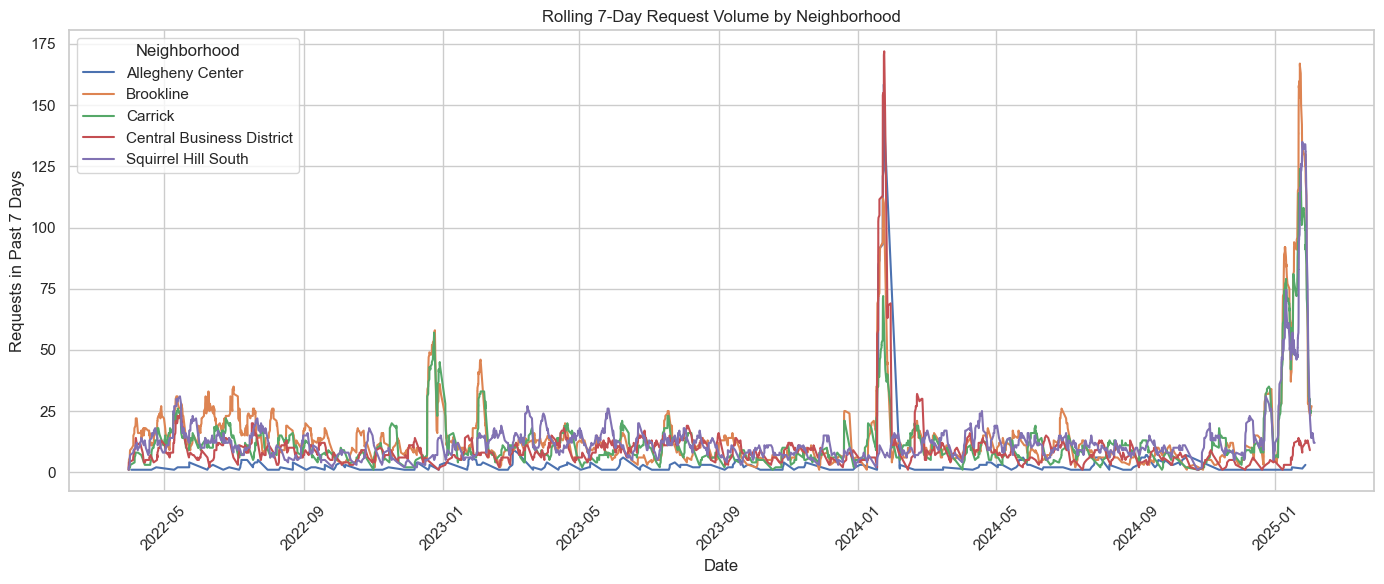

In [ ]:
<!-- # 设置绘图风格
sns.set(style='whitegrid', rc={'figure.figsize': (14, 6)})

# 可选：选择几个 neighborhood 进行可视化
selected_neighborhoods = dpw_sm_part3['neighborhood'].value_counts().head(5).index

# 筛选出这些 neighborhood 的数据
plot_df = dpw_sm_part3[dpw_sm_part3['neighborhood'].isin(selected_neighborhoods)]

# 绘制折线图
sns.lineplot(data=plot_df, x='create_date_et', y='requests_last_week', hue='neighborhood')

plt.title('Rolling 7-Day Request Volume by Neighborhood')
plt.xlabel('Date')
plt.ylabel('Requests in Past 7 Days')
plt.xticks(rotation=45)
plt.legend(title='Neighborhood')
plt.tight_layout()
plt.show() -->

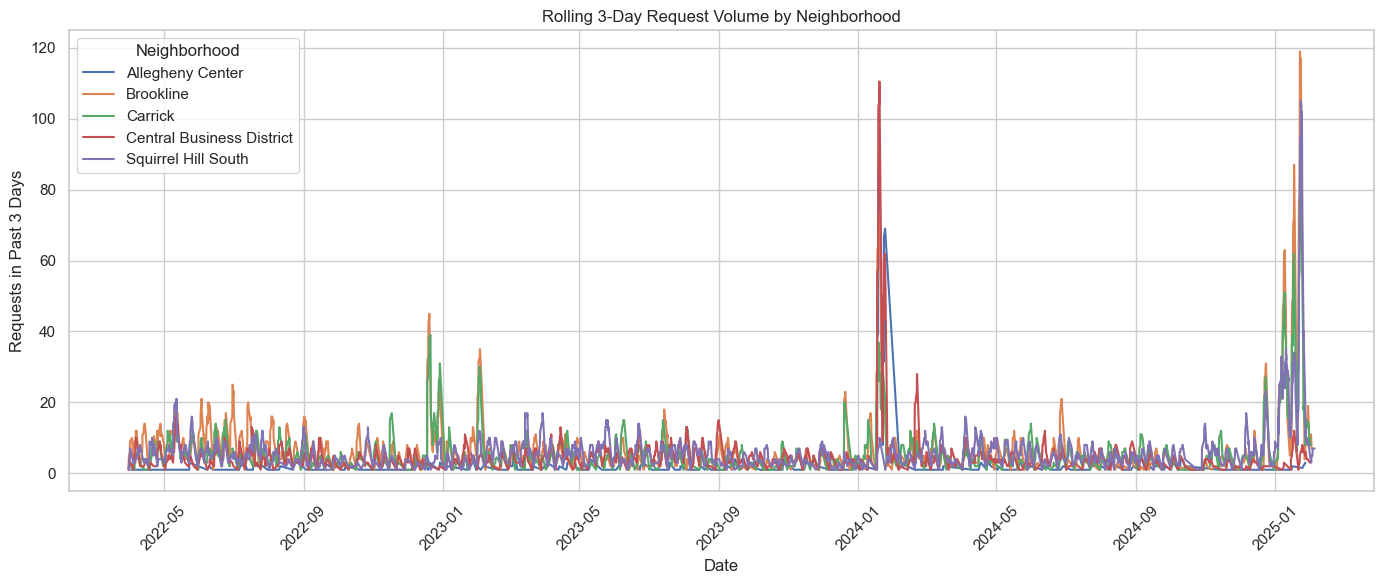

In [ ]:
<!-- sns.lineplot(data=plot_df, x='create_date_et', y='requests_last_3_days', hue='neighborhood')

plt.title('Rolling 3-Day Request Volume by Neighborhood')
plt.xlabel('Date')
plt.ylabel('Requests in Past 3 Days')
plt.xticks(rotation=45)
plt.legend(title='Neighborhood')
plt.tight_layout()
plt.show() -->

*Model Training*
 

In [91]:
dpw_sm_part3['high_risk'] = (
    (dpw_sm_part3['is_multiple_request'] == 1) |
    (dpw_sm_part3['not_close_long_time_request'] == 1)
).astype(int)

In [93]:
categorical_features = ['request_type_name', 'create_month', 'neighborhood', 'geo_accuracy',
                        'police_zone', 'council_district', 'ward', 'origin'] #type, time, space related feature
numerical_features = ['is_weekend', 'is_working_hours']

# impute and encode for categorical features
to_str = FunctionTransformer(lambda x: x.astype(str), validate=False)
categorical_transformer = Pipeline(steps=[
    ('to_str', to_str),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # 替换 NaN
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),  # 数值特征不做处理
        ('cat', categorical_transformer, categorical_features)  # 分类特征进行 OneHotEncoder 编码
    ])

In [108]:
X = dpw_sm_part3[categorical_features + numerical_features]
y = dpw_sm_part3["high_risk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_processed, y_train)



In [109]:
classifier = LogisticRegression(max_iter=1000,  class_weight='balanced')
classifier.fit(X_train_resampled, y_train_resampled)
y_prob = classifier.predict_proba(X_test_processed)[:, 1]

# 改变 threshold（默认是0.5）
threshold = 0.5  # 举例：提高 recall
y_pred_adjusted = (y_prob >= threshold).astype(int)

In [110]:
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

AUC: 0.6916148954724449
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      7377
           1       0.10      0.62      0.18       441

    accuracy                           0.68      7818
   macro avg       0.54      0.65      0.49      7818
weighted avg       0.92      0.68      0.76      7818

Confusion matrix:
 [[5024 2353]
 [ 169  272]]


In [ ]:
# lightLGB模型
lgb = LGBMClassifier(
    class_weight='balanced',  # 或者设置 scale_pos_weight=int(neg_class / pos_class)
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

In [ ]:
lgb.fit(X_train_resampled, y_train_resampled)
y_prob = lgb.predict_proba(X_test_processed)[:, 1]
# 改变 threshold（默认是0.5）
threshold = 0.3  # 举例：提高 recall
y_pred_adjusted = (y_prob >= threshold).astype(int)
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

[LightGBM] [Info] Number of positive: 29507, number of negative: 29507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15996
[LightGBM] [Info] Number of data points in the train set: 59014, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC: 0.7298187631656521
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7377
           1       0.27      0.19      0.22       441

    accuracy                           0.93      7818
   macro avg       0.61      0.58      0.59      7818
weighted avg       0.91      0.93      0.92      7818

Confusion matrix:
 [[7151  226]
 [ 358   83]]


In [116]:
# XGBoost
scale_pos_weight = (y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_resampled, y_train_resampled)

d:\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:17:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [117]:
y_prob = lgb.predict_proba(X_test_processed)[:, 1]
# 改变 threshold（默认是0.5）
threshold = 0.5  # 举例：提高 recall
y_pred_adjusted = (y_prob >= threshold).astype(int)
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_adjusted))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

AUC: 0.7298187631656521
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7377
           1       0.54      0.13      0.21       441

    accuracy                           0.94      7818
   macro avg       0.74      0.56      0.59      7818
weighted avg       0.93      0.94      0.93      7818

Confusion matrix:
 [[7327   50]
 [ 383   58]]
